In [243]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import sqlalchemy as db
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

np.seterr(divide = 'ignore')
pd.set_option('display.max_rows', 500)

In [244]:
load_dotenv()

# config and credentials
server = os.getenv('server')
database = os.getenv('database')
username = os.getenv('username')
password = os.getenv('password')

# connection
engine = db.create_engine(
    'mssql://{}:{}@{}/{}?driver=ODBC+Driver+18+for+SQL+Server'.format(
        username, password, server, database
    )
)

# establish connection
connection = engine.connect()

In [3]:
def get_sample_particulars(df):
    print('Number of observations: {:,}'.format(len(df.index)))
    print('Returns: Mean: {:.5f} | Median: {:.5f} | Std returns: {:.5f}'.format(
        100 * df['R'].mean(), 100 * df['R'].median(), 100 * df['R'].std()))
    print('Volume mean: {:.5f}'.format(df['TDvolume'].mean()))
    print('Coupon mean: {:.5f}'.format(df['Coupon'].mean()))
    print('Yield mean: {:.5f}'.format(df['Yield'].mean()))

### Query Selection

In [4]:
# vanilla
bondReturns_vanilla = '''
    SELECT
        Date,
        Cusip,
        CompanySymbol,
        Coupon,
        Yield,
        TDvolume,
        RetEom / 100 AS R,
        RatingNum,
        RatingClass,
        CASE
            WHEN DATEDIFF(DAY, OfferingDate, Maturity) * 1.0 / 360 < 5 THEN 1
            WHEN DATEDIFF(DAY, OfferingDate, Maturity) * 1.0 / 360 < 15 THEN 2
            ELSE 3
        END AS MaturityBand
    FROM 
        BondReturns
    WHERE
        Cusip IN (SELECT DISTINCT CusipId FROM Trace_filtered_withRatings )
'''

# top performing bonds
bondReturns_topPerforming = '''
    SELECT
        A.Date,
        A.Cusip,
        A.CompanySymbol,
        A.Coupon,
        A.Yield,
        A.TDvolume,
        A.RetEom / 100 AS R,
        A.RatingNum,
        A.RatingClass,
        CASE
            WHEN DATEDIFF(DAY, A.OfferingDate, A.Maturity) * 1.0 / 360 < 5 THEN 1
            WHEN DATEDIFF(DAY, A.OfferingDate, A.Maturity) * 1.0 / 360 < 15 THEN 2
            ELSE 3
        END AS MaturityBand
    FROM
        BondReturns A
    INNER JOIN (
        SELECT
            Date,
            CompanySymbol,
            MAX(TDvolume) AS MaxVolume
        FROM 
            BondReturns
        WHERE
            Cusip IN (SELECT DISTINCT CusipId FROM Trace_filtered_withRatings)
        GROUP BY
            Date,
            CompanySymbol
    ) B ON A.Date = B.Date AND A.CompanySymbol = B.CompanySymbol AND A.TDvolume = B.MaxVolume
'''

In [5]:
query_selection = input('Please type: vanilla | topPerforming\n')

Please type: vanilla | topPerforming
vanilla


In [274]:
if query_selection == 'vanilla':
    query = bondReturns_vanilla
    query_n = 'bondReturns_vanilla'
else:
    query = bondReturns_topPerforming
    query_n = 'bondReturns_topPerforming'

# read sql
# df = pd.read_sql(query, connection)
# df.to_csv('data/output/bonds/{}.csv'.format(query_n), index=False)

# read csv
df = pd.read_csv('data/output/bonds/{}.csv'.format(query_n))
df['Date'] = pd.to_datetime(df['Date'])

### Quantile Filtering and Outlier Visualization

In [275]:
df['quantiles'] = pd.qcut(df.R, np.linspace(0, 1, 201), labels=np.linspace(0, 1, 200)).astype(float)
df['outliers'] = np.where((df['quantiles'] > 0.995) | (df['quantiles'] < 0.005), 1, 0)
df['Year'] = df['Date'].dt.year

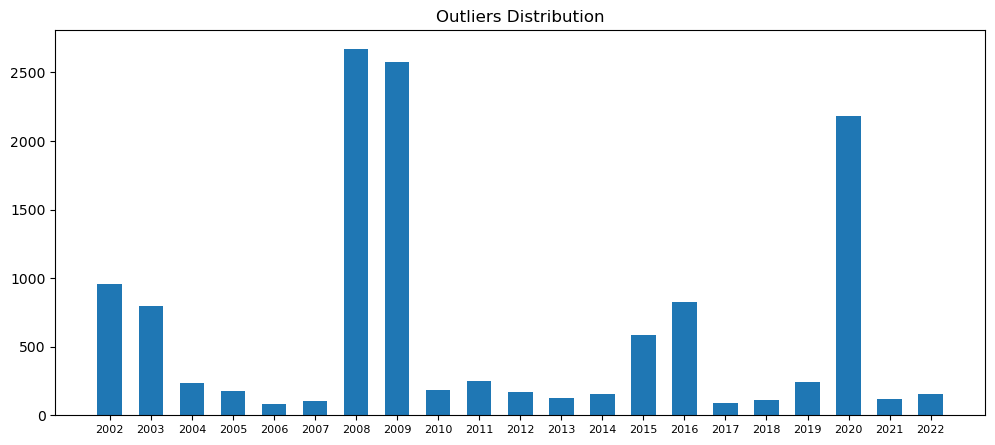

In [276]:
df_g = df.groupby('Year')['outliers'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.title('Outliers Distribution')
plt.bar(df_g['Year'], df_g['outliers'], width = 0.6)
plt.xticks([i for i in range(2002, 2023)], fontsize=8)
plt.show()

In [277]:
# filter out outliers
df = df[df['outliers'] == 0]

### Exploratory Analysis

In [278]:
df['Cusip'].nunique()

60013

In [279]:
# number of entries
df['RatingClass'].value_counts(dropna=False)

0.IG    1081436
1.HY     227090
NaN      138051
Name: RatingClass, dtype: int64

In [280]:
# number of distinct Cusips
df.groupby('RatingClass', dropna=False).Cusip.nunique()

RatingClass
0.IG    22601
1.HY     5662
NaN     38275
Name: Cusip, dtype: int64

In [281]:
# drop NR
df = df.dropna(subset=['RatingNum'])

# number of entries
df['MaturityBand'].value_counts(dropna=False)

2    844810
3    386935
1     78071
Name: MaturityBand, dtype: int64

In [282]:
# number of distinct Cusips
df.groupby('MaturityBand').Cusip.nunique()

MaturityBand
1     4327
2    17281
3     4484
Name: Cusip, dtype: int64

In [283]:
df['Cusip'].nunique()

26092

In [284]:
# filtering
# df = df[df['MaturityBand'] == 1]
# df = df[df['RatingClass'] == '1.HY']

In [285]:
get_sample_particulars(df)

Number of observations: 1,309,816
Returns: Mean: 0.40973 | Median: 0.29740 | Std returns: 2.68072
Volume mean: 51078836.47833
Coupon mean: 5.32929
Yield mean: 4.40405


### Portfolio Analysis

In [286]:
# fill NULL returns
df['R'] = df['R'].fillna(0)

# log returns
df['logR'] = np.log(1 + df['R'])

In [287]:
J = 3 # formation period

df_ = df[
    ['Cusip', 'Date', 'R', 'logR']
].sort_values(['Cusip', 'Date']).set_index('Date')

cumr = df_.groupby(['Cusip'])['logR'].rolling(J, min_periods=J).sum().reset_index()
cumr = cumr.rename(columns = {'logR': 'SumLogR'})

cumr['CumRet'] = np.exp(cumr['SumLogR'])-1

In [288]:
r = 10 # momentum ranking

cumr = cumr.dropna(axis=0, subset=['CumRet'])

cumr['MomR'] = cumr.groupby('Date')['CumRet'].transform(lambda x: pd.qcut(x, r, labels=False))
cumr['MomR'] = 1 + cumr['MomR'].astype(int)

In [289]:
cumr.groupby('MomR')['CumRet'].mean()

MomR
1    -0.044013
2    -0.014981
3    -0.005499
4     0.001344
5     0.007316
6     0.013345
7     0.019952
8     0.028274
9     0.040829
10    0.077163
Name: CumRet, dtype: float64

In [291]:
K = 3 # Holding Period Length: K can be between 3 to 12 months

cumr['form_date'] = cumr['Date']
cumr['medate'] = cumr['Date'] + MonthEnd(0)
cumr['hdate1'] = cumr['medate'] + MonthBegin(1)
cumr['hdate2'] = cumr['medate'] + MonthEnd(K)
cumr = cumr[['Cusip', 'form_date','MomR','hdate1','hdate2', 'CumRet']]

port = pd.merge(df[['Cusip', 'Date', 'R']], cumr, on=['Cusip'], how='inner')
port = port[(port['hdate1'] <= port['Date']) & (port['Date'] <= port['hdate2'])]
port = port[['Cusip','form_date', 'MomR', 'hdate1','hdate2', 'Date', 'R', 'CumRet']]
port['Date'] = pd.to_datetime(port['Date'])

In [292]:
cumr_port = port.groupby(['Date','MomR', 'form_date'])['CumRet'].mean().reset_index()

start_yr = cumr_port['Date'].dt.year.min()+2
cumr_port = cumr_port.loc[cumr_port.Date.dt.year >= start_yr]
cumr_port = cumr_port.sort_values(by=['Date','MomR'])

ewret = cumr_port.groupby(['Date','MomR'])['CumRet'].mean().reset_index()
ewstd = cumr_port.groupby(['Date','MomR'])['CumRet'].std().reset_index()

ewret = ewret.rename(columns={'CumRet':'ewret'})
ewstd = ewstd.rename(columns={'CumRet':'ewretstd'})

ewretdf = pd.merge(ewret, ewstd, on=['Date','MomR'], how='inner')
ewretdf = ewretdf.sort_values(by=['MomR', 'Date'])

In [293]:
ewretdf.groupby(['MomR'])['ewret'].describe()[['count','mean', 'std']].reset_index()

,MomR,count,mean,std
0,1,225.0,-0.043448,0.034616
1,2,225.0,-0.014726,0.025230
2,3,225.0,-0.005097,0.020418
3,4,225.0,0.001777,0.017823
4,5,225.0,0.007764,0.016841
5,6,225.0,0.013776,0.017038
6,7,225.0,0.020392,0.018517
7,8,225.0,0.028702,0.021575
8,9,225.0,0.041210,0.026875
9,10,225.0,0.076892,0.040249


In [295]:
ewret_t = ewretdf.pivot(index='Date', columns='MomR', values='ewret') 

# Add prefix port in front of each column 
ewret_t = ewret_t.add_prefix('port') 
ewret_t = ewret_t.rename(columns={'port1':'losers', 'port10':'winners'}) 
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers
ewret_t.head()

MomR,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
Date,,,,,,,,,,,
2004-01-31,-0.027718,-0.000733,0.004703,0.009398,0.014901,0.021604,0.029777,0.041311,0.059218,0.111809,0.139527
2004-02-29,-0.020733,0.000968,0.006120,0.010882,0.016165,0.022514,0.030232,0.041486,0.059308,0.114121,0.134854
2004-03-31,-0.019259,0.001238,0.006509,0.010913,0.015521,0.020960,0.027565,0.036958,0.052238,0.102188,0.121447
2004-04-30,-0.018717,0.003937,0.009479,0.014754,0.020004,0.025602,0.031786,0.039851,0.052587,0.092633,0.111350
2004-05-31,-0.033581,-0.004739,0.002196,0.007918,0.012995,0.017851,0.022902,0.029331,0.039379,0.071755,0.105336


In [296]:
ewret_t['cumret_winners'] = (1 + ewret_t.winners).cumprod() - 1 
ewret_t['cumret_losers'] = (1 + ewret_t.losers).cumprod() - 1
ewret_t['cumret_long_short'] = (1 + ewret_t.long_short).cumprod() - 1

mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame() 
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index() 
mom_mean

,MomR,mean
0,winners,0.076892
1,losers,-0.043448
2,long_short,0.120340


In [297]:
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'], 0.0)).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'], 0.0)).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'], 0.0)).to_frame().T

t_losers['MomR'] = 'losers' 
t_winners['MomR'] = 'winners' 
t_long_short['MomR'] = 'long_short'

In [298]:
t_output = pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p and format output 
mom_output = pd.merge(mom_mean, t_output, on=['MomR'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format) 
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format) 
mom_output['p-value'] = mom_output['p-value'].map('{:.2f}'.format) 

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          MomR    mean  t-stat p-value
0     winners   7.69%   28.66    0.00
1      losers  -4.34%  -18.83    0.00
2  long_short  12.03%   36.28    0.00


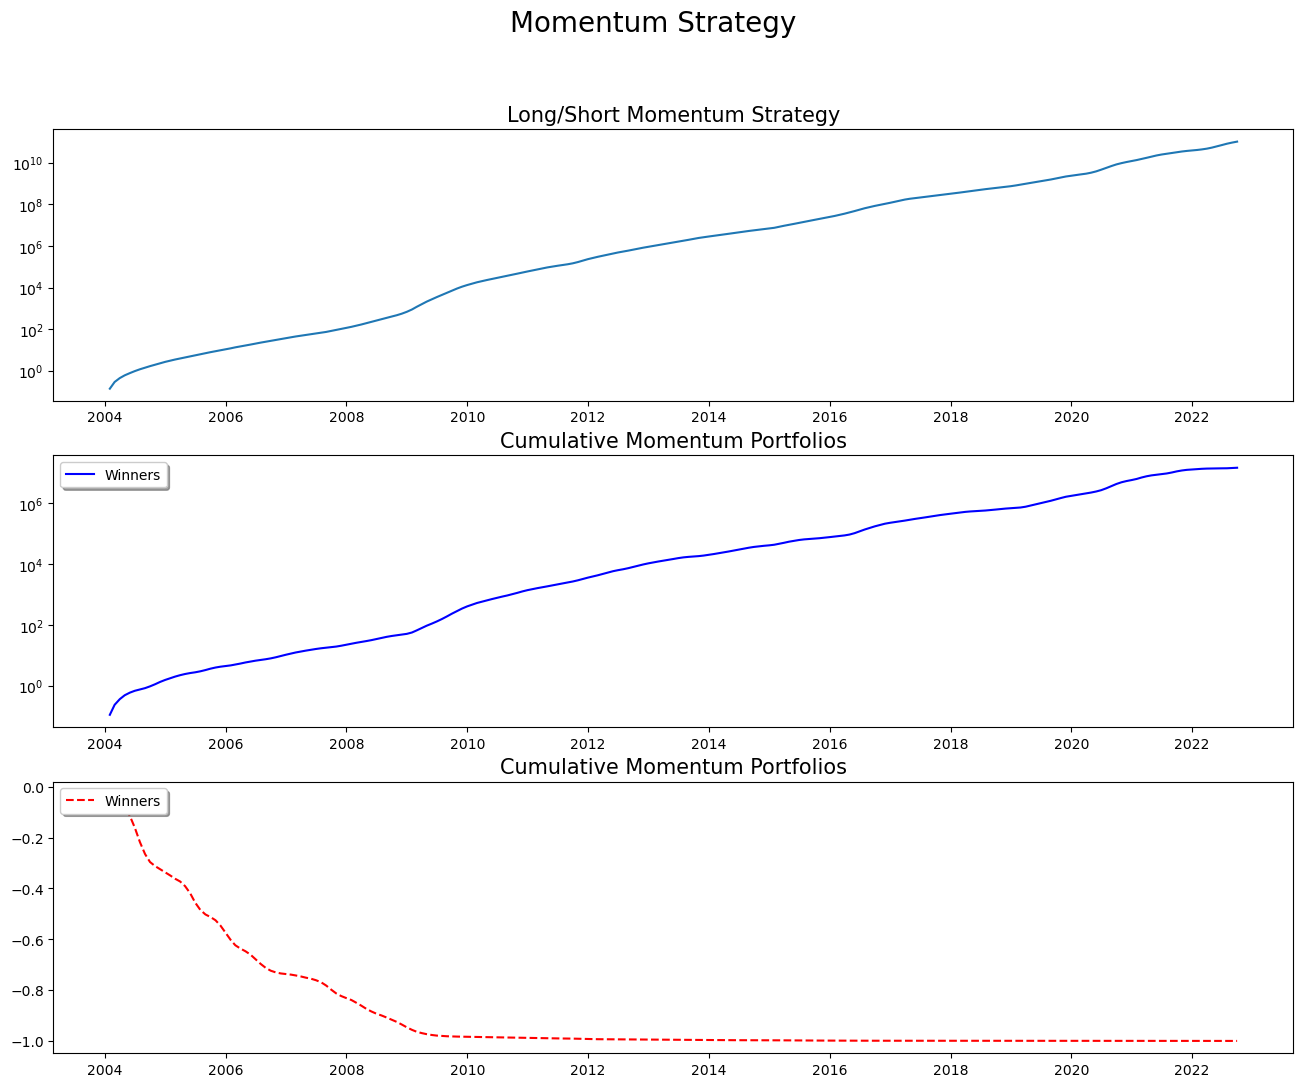

In [328]:
plt.figure(figsize=(16, 12)) 
plt.suptitle('Momentum Strategy', fontsize=20) 

ax1 = plt.subplot(311) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(ewret_t['cumret_long_short'])
ax1.set_yscale('log')

ax2 = plt.subplot(312) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15)
ax2.plot(ewret_t['cumret_winners'], 'b-') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True) 
ax2.set_yscale('log')

ax3 = plt.subplot(313) 
ax3.set_title('Cumulative Momentum Portfolios', fontsize=15)
ax3.plot(ewret_t['cumret_losers'], 'r--') 
ax3.legend(('Winners','Losers'), loc='upper left', shadow=True) 
# ax3.set_yscale('log')